In [1]:
cd C:\Users\Avell\Aula1

C:\Users\Avell\Aula1


## Introdução a CONVNETS (Redes Neurias Convolucionais)

Estamos prestes a mergulhar na teoria do que são os convnets e por que eles têm tanto sucesso em tarefas de visão computacional. Mas, primeiro, vamos dar uma olhada prática em um exemplo simples de convnet. Vamos treinar uma Convnet do zero para um pequeno conjunto de dados.
Ter que treinar um modelo de classificação de imagem usando muito poucos dados é uma situação comum, que você provavelmente encontrará na prática se fizer visão computacional em um contexto profissional. Algumas “poucas” amostras podem significar de algumas centenas a algumas dezenas de milhares de imagens. Como um exemplo prático, vamos nos concentrar na classificação de imagens como cães ou gatos, em um conjunto de dados contendo 3.000 fotos de gatos e cães (1.500 gatos, 1.500 cães). Nós usaremos 2.000 imagens para treinar e 1000 para validar.

As linhas de código a seguir mostram a aparência de um convnet básico. É uma pilha de camadas Conv2D e MaxPooling2D. Você verá em um minuto exatamente o que eles fazem.

## Seção 1
Nesta seção, revisaremos uma estratégia básica para resolver esse problema: treinar um novo modelo do zero usando os poucos dados que você tem. Você vai começar treinando ingenuamente um pequeno convnet nas 2.000 amostras de treinamento, sem qualquer regularização, para definir uma linha de base para o que pode ser alcançado.
Isso o levará a uma precisão de classificação de 71%. Nesse ponto, o principal problema será o ***overfitting***. Em seguida, apresentaremos a ***data augmentation***, uma técnica poderosa para mitigar o sobreajuste na visão computacional. Ao usar o aumento de dados, você melhorará a rede para alcançar uma precisão de 82%.

Na próxima seção, revisaremos mais duas técnicas essenciais para a aplicação de aprendizado profundo em pequenos conjuntos de dados: extração de recursos com uma rede pré-treinada (que o levará a uma precisão de 90% a 96%) e ajuste fino de uma rede pré-treinada ( isso o levará a uma precisão final de 97%). Juntas, essas três estratégias - treinar um pequeno modelo do zero, fazer extração de recursos usando um modelo pré-treinado e fazer o ajuste fino de um modelo pré-treinado - constituirão sua caixa de ferramentas futura para lidar com o problema de desempenho na classificação de imagens com pequenos conjuntos de dados.


In [1]:
#Importato as bibliotecas e criando nossa CONVNET
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras import models

model = models.Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



Vejamos como as dimensões dos mapas de características mudam com cada camada sucessiva:

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Compilando o Modelo para Treinamento

Para a etapa de compilação, isaremos como otimizador RMSprop. 
Devido ser um problema de classificação binária, temos que colocar apenas 1 neurônio na camada de saída, sendo assim, a função de ativação a ser utilizada será a sigmóide e a Loos function, será a binary-crossentropy. Segue a tabela abaixo para utilizá-la como referência.


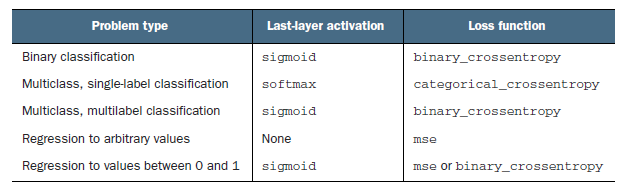

In [3]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

## Processando os Dados com Data Augmentation

O **overfitting** é causado por ter poucas amostras para aprender, tornando você incapaz de treinar um modelo que pode generalizar para novos dados. Com dados infinitos, seu modelo seria exposto a todos os aspectos possíveis da distribuição de dados em questão: você nunca ajustaria demais.
**Data Augmentation** adota a abordagem de gerar mais dados de treinamento a partir de amostras de treinamento existentes, aumentando as amostras por meio de uma série de transformações aleatórias que produzem imagens de aparência confiável. O objetivo é que, na hora do treinamento, seu modelo nunca veja exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo a mais aspectos dos dados e generalizar melhor.
No Keras, isso pode ser feito configurando uma série de transformações aleatórias a serem realizadas nas imagens lidas pela instância **ImageDataGenerator**. Vamos começar com um exemplo.
Vamos ver algumas das opções disponíveis (para mais informações, consulte a documentação do Keras). 

***rotation_range*** é um valor em graus (0–180), um intervalo dentro do qual girar as imagens aleatoriamente.

***width_shift*** e ***height_shift*** são intervalos (como uma fração da largura ou altura total) dentro dos quais as imagens são traduzidas aleatoriamente na vertical ou na horizontal.

***shear_range*** é para aplicar transformações de cisalhamento aleatoriamente.

***zoom_range*** serve para ampliar aleatoriamente as fotos.

***horizontal_flip*** serve para virar aleatoriamente metade das imagens horizontalmente - relevante quando não há suposições de assimetria horizontal (por exemplo, imagens do mundo real).

***fill_mode*** é a estratégia usada para preencher os pixels recém-criados, que podem aparecer após uma rotação ou mudança de largura / altura.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

#Convertendo o tamanho das imagens
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
      'dataset/train/',
      target_size = (150, 150),
      batch_size = 20,
      class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
      'dataset/validation/',
      target_size = (150, 150),
      batch_size = 20,
      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


## Treinando o Modelo

Vamos ajustar o modelo aos dados usando o **generator**. Fazemos isso usando o método ***fit_generator***, o equivalente a ***fit*** para geradores de dados como este. Ele espera como primeiro argumento um gerador Python que produzirá lotes de entradas e alvos indefinidamente, como este faz.
Como os dados são gerados incessantemente, o modelo **Keras** precisa saber quantas amostras retirar do gerador antes de declarar o término de uma época. Este é o papel do argumento ***steps_per_epoch***: depois de extrair lotes de ***steps_per_epoch*** do gerador - isto é, após ter executado para etapas de descida de gradiente de ***steps_per_epoch*** - o processo de ajuste irá para a próxima época. Neste caso, os lotes (***batch_size***) são 20 amostras, então serão necessários 100 lotes até que você veja
sua meta de 2.000 amostras.
Ao usar ***fit_generator***, você pode passar um argumento ***validation_data***, tanto quanto com o método ***fit***. É importante observar que este argumento pode ser um gerador de dados, mas também pode ser uma tupla de matrizes Numpy. Se você passar um gerador como ***validation_data***, espera-se que esse gerador produza lotes de dados de validação indefinidamente; portanto, você também deve especificar o argumento ***validation_steps***, que informa ao processo quantos lotes retirar do gerador de validação para avaliação.


In [5]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 30,
      validation_data = validation_generator,
      validation_steps = 50)

C:\Users\Avell\AppData\Local\Temp\ipykernel_16788\1719615851.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 32s 261ms/step - loss: 0.7014 - acc: 0.4970 - val_loss: 0.6921 - val_acc: 0.5110
Epoch 2/30
100/100 [==============================] - 18s 181ms/step - loss: 0.6925 - acc: 0.5170 - val_loss: 0.6865 - val_acc: 0.5560
Epoch 3/30
100/100 [==============================] - 15s 153ms/step - loss: 0.6885 - acc: 0.5410 - val_loss: 0.6774 - val_acc: 0.5790
Epoch 4/30
100/100 [==============================] - 15s 148ms/step - loss: 0.6799 - acc: 0.5785 - val_loss: 0.7602 - val_acc: 0.5290
Epoch 5/30
100/100 [==============================] - 17s 172ms/step - loss: 0.6685 - acc: 0.5850 - val_loss: 0.6892 - val_acc: 0.5760
Epoch 6/30
100/100 [==============================] - 17s 167ms/step - loss: 0.6545 - acc: 0.6020 - val_loss: 0.6445 - val_acc: 0.6150
Epoch 7/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6575 - acc: 0.6125 - val_loss: 0.6608 - val_acc: 0.5780
Epoch 8/30
100/100 [==============================] - 1

##Salvando o Modelo

In [8]:
model.save('cats_and_dogs_small_1.h5')

## Exibindo curvas de perda (Loss) e precisão (accuracy) durante o treinamento

Vamos representar graficamente a ***Loss*** e a ***accuracy*** do modelo sobre os dados de treinamento e validação durante o treinamento

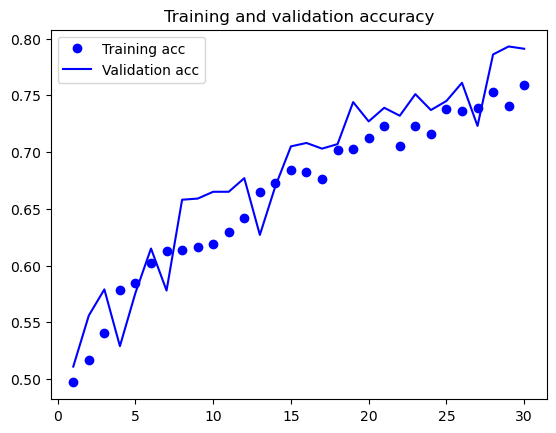

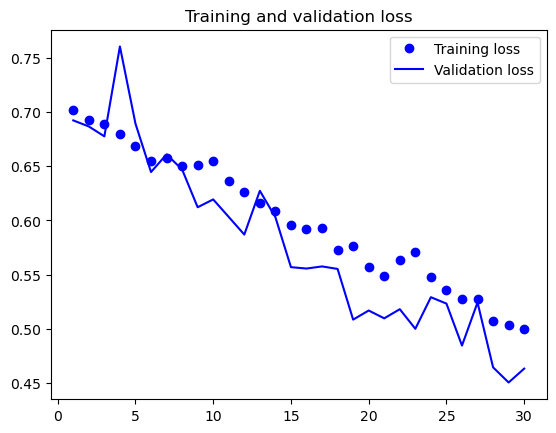

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()